In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os
from os.path import join, dirname, exists
import matplotlib.pyplot as plt
import pickle
from torchvision.utils import make_grid

torch.cuda.is_available() # Yaah! We can use GPU now.

True

In [0]:
def savefig(fname, show_figure=True):
    if not exists(dirname(fname)):
        os.makedirs(dirname(fname))
    plt.tight_layout()
    plt.savefig(fname)
    if show_figure:
        plt.show()

def save_training_plot(train_losses, test_losses, title, fname):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label='test_losses')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    savefig(fname)

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def load_pickled_data(fname, include_labels=False):
    with open(fname, 'rb') as f:
        data = pickle.load(f)

    train_data, test_data = data['train'], data['test']
    if 'mnist.pkl' or 'shapes.pkl' in fname:
        train_data = (train_data > 127.5).astype('uint8')
        test_data = (test_data > 127.5).astype('uint8')
    if 'celeb.pkl' in fname:
        train_data = train_data[:, :, :, [2, 1, 0]]
        test_data = test_data[:, :, :, [2, 1, 0]]
    if include_labels:
        return train_data, test_data, data['train_labels'], data['test_labels']
    return train_data, test_data

def quantize(images, n_bits):
    images = np.floor(images / 256. * 2 ** n_bits)
    return images.astype('uint8')

def model_save_results(dataid, model_wrapper, method):
    if dataid == 1:
        train_data, test_data = load_pickled_data('/content/drive/My Drive/mnist.pkl')
        img_shape = (28, 28)
        train_losses, test_losses, samples = model_wrapper(train_data, test_data,
                                                           img_shape, dataid, method)
        samples = samples.astype('float32') * 255

    if dataid == 2:
        train_data, test_data = load_pickled_data('/content/drive/My Drive/mnist_colored.pkl')
        img_shape = (28, 28, 3)
        train_losses, test_losses, samples = model_wrapper(train_data, test_data,
                                                           img_shape, dataid, method)

        samples = samples.astype('float32') / 3 * 255

    print(f'Final Test Loss: {test_losses[-1]:.4f}')
    save_training_plot(train_losses, test_losses, 'Dataset{dataid} Train Plot',
                       'results/dataset{dataid}_train_plot.png')
    show_samples(samples, 'results/dataset{dataid}_samples.png')

Over the course of training, we will record the average negative log-likelihood (nats/dim) of the training data (per minibatch)
and test data (for entire test data).

In [0]:
def train(model, train_loader, optimizer, epoch, grad_clip=None):
    # Explicitly state our intention to train the model,
    # since some layers may behave differently during train and test time
    model.train()
    train_losses = []
    for x in range(tqdm_notebook(train_loader, desc='Batch', leave=False)):  # for each minibatch of size 128
        x = x.cuda().contiguous() # put minibatch into GPU
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            # clip the gradient to be grad_clip if exceed
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        # loss.item() extract the loss's value as a Python float
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()

    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


# train_args includes [epochs, lr, grad_clip]
def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()

        train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses

In [0]:
class maskedConv2d(nn.Conv2d):
    # *args may includes usual arguments as in_channels, out_channels, kernel_size, stride, padding and so on
    def __init__(self, mask_type, *args, color=False, condition_size=None, **kwargs):
        assert mask_type in {"A", "B"}
        super().__init__(*args, **kwargs)  # initialize some kernels
        self.color = color
        self.condition_size = condition_size
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        # cond could be a target label or an image
        if condition_size:
            if len(condition_size) == 1:
                self.cond_func = nn.Linear(
                    condition_size[0], self.out_channels)
            else:
                self.cond_func = nn.Conv2d(
                    condition_size[0], self.out_channels, kernel_size=3, padding=1)

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = F.conv2d(input=x, weight=self.weight*self.mask, bias=self.bias, stride=self.stride,
                       padding=self.padding, dilation=self.dilation, groups=self.groups)
        if self.condition_size:
            if len(self.condition_size) == 1:
                out += self.cond_func(cond).view(batch_size, -1, 1, 1)
            else:
                out += self.cond_func(cond)
        return out
    
    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if self.color:
            assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
            one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
            if mask_type == 'B':
                self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
                self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
                self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
            else:
                self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
                self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
        else:
            if mask_type == 'B':
                self.mask[:, :, k // 2, k // 2] = 1

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):  # kwargs include color and condition_size
        super().__init__()
        self.block = nn.ModuleList([
            nn.ReLU(),
            maskedConv2d('B', in_channels, in_channels//2, 1, **kwargs),
            nn.ReLU(),
            maskedConv2d('B', in_channels//2, in_channels//2, 7, padding = 3, **kwargs),
            nn.ReLU(),
            maskedConv2d('B', in_channels//2, in_channels, 1, **kwargs)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, maskedConv2d):
                out = layer(out, cond)
            else:
                out = layer(out)
        return out + x


class LayerNorm(nn.LayerNorm):
    def __init__(self, color, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color = color

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        if self.color:
            x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()


class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, n_filters=64, kernel_size=7,
                 n_layers=5, color=False, condition_size=None, res_connect=False):
        assert n_layers >= 2
        super().__init__()
        n_channels = input_shape[0]

        kwargs = dict(condition_size=condition_size, color=color)

        if res_connect:
            block = lambda: ResidualBlock(n_filters, **kwargs)
        else:
            block = lambda: maskedConv2d('B', n_filters, n_filters, kernel_size=kernel_size,
                                        padding=kernel_size//2, **kwargs)

        model = nn.ModuleList([maskedConv2d('A', n_channels, n_filters, kernel_size=kernel_size,
                                            padding=kernel_size//2, **kwargs)])

        for _ in range(n_layers):
            if color:
                model.append(LayerNorm(color, n_filters//3))
            else:
                model.append(LayerNorm(color, n_filters))
            model.extend([nn.ReLU(), block()])
        model.extend([nn.ReLU(), maskedConv2d(
            'B', n_filters, n_filters, 1, **kwargs)])
        model.extend([nn.ReLU(), maskedConv2d(
            'B', n_filters, n_colors*n_channels, 1, **kwargs)])

        if condition_size:
            if len(condition_size) == 1:
                self.cond_func = lambda x: x
            else:
                self.cond_func = nn.Sequential(nn.Conv2d(condition_size[0], n_filters, 3, padding=1),
                                               nn.ReLU(),
                                               nn.Conv2d(
                                                   n_filters, n_filters, 3, padding=1),
                                               nn.ReLU(),
                                               nn.Conv2d(
                                                   n_filters, n_filters, 3, padding=1),
                                               nn.ReLU())
        self.net = model
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_channels = n_channels
        self.color = color
        self.condition_size = condition_size

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        if self.condition_size:
            cond = self.cond_func(cond)
        for layer in self.net:
            if isinstance(layer, maskedConv2d) or isinstance(layer, ResidualBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)

        return out.view(batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
        

    def loss(self, x, cond=None):
        return F.cross_entropy(self(x, cond=cond), x.long())

    def sample(self, n, cond=None):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for h in range(self.input_shape[1]):
                for w in range(self.input_shape[2]):
                    for c in range(self.input_shape[0]):
                        logits = self(samples, cond=cond)[
                            :, :, c, h, w]
                        probs = F.softmax(logits, dim=1)
                        samples[:, c, h, w] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [0]:
def model_wrapper(train_data, test_data, image_shape, dataid, method):
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    if dataid == 1:
        H, W = image_shape
        if method == "PixelCNN":
            model = PixelCNN((1, H, W), 2, n_layers=5).cuda()
        elif method == "GatedPixelCNN":
            model = GatedPixelCNN((1, H, W), 2, n_filters=64, n_layers=5).cuda()
        train_args=dict(epochs=10, lr=1e-3)
    if dataid == 2:
        H, W, C = image_shape
        if method == "PixelCNN":
            model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8,
                            res_connect=True, color=True).cuda()
        elif method == "GatedPixelCNN":
            model = GatedPixelCNN((C, H, W), 4, n_filters=120, n_layers=8).cuda()
        train_args = dict(epochs=15, lr=1e-3, grad_clip=1)
    train_loader = data.DataLoader(
        train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             train_args)
    samples = model.sample(100)
    return train_losses, test_losses, samples

In [0]:
class multiLayerNorm(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.LayerNorm_v = LayerNorm(False, n_filters)
        self.LayerNorm_h = LayerNorm(False, n_filters)
    
    def forward(self, x):
        vx, hx = x.chunk(2, dim=1) # Split according to channels
        vx = self.LayerNorm_v(vx); hx = self.LayerNorm_h(hx)
        return torch.cat((vx, hx), dim=1)

class gatedConv2d(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, kW=7, 
                 padding=3):
        super().__init__()

        self.v = nn.Conv2d(in_channels, 2*out_channels, 
                                 kernel_size=kW, padding=padding, bias=False)
        self.h = nn.Conv2d(in_channels, 2*out_channels, 
                                 kernel_size=(1, kW), padding=(0, padding), bias=False)
        self.v_h = nn.Conv2d(2*out_channels, 2*out_channels, kernel_size=1, bias=False)
        self.h_h = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        
        self.register_buffer('vmask', torch.ones_like(self.v.weight))
        self.register_buffer('hmask', torch.ones_like(self.h.weight))
        self.vmask[:, :, kW//2+1:, :] = 0
        self.hmask[:, :, :, kW//2+1:] = 0
        if mask_type == 'A':
            self.hmask[:, :, :, kW//2] = 0

    def down_shift(self, x):
        x = x[:, :, :-1, :]
        pad = nn.ZeroPad2d((0, 0, 1, 0))
        return pad(x)

    def forward(self, x):
        # First, we split x into two halves, each corresponding seperately to v and h
        vx, hx = x.chunk(2, dim=1)
        self.v.weight.data *= self.vmask
        self.h.weight.data *= self.hmask
        vx = self.v(vx)
        hx_res = self.h(hx) + self.v_h(self.down_shift(vx))
        vx_g, vx_c = vx.chunk(2, dim=1)
        vx = torch.sigmoid(vx_g) * torch.tanh(vx_c)
        hx_res_g, hx_res_c = hx_res.chunk(2, dim=1)
        hx_res = self.h_h(torch.tanh(hx_res_c) * torch.sigmoid(hx_res_g))
        hx += hx_res 
        return torch.cat((vx, hx), dim=1) 

class GatedPixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, n_filters=120, kernel_size=7, n_layers=6):
        super().__init__()
        n_channels = input_shape[0]
        block = lambda: gatedConv2d("B", n_filters, n_filters, kW=kernel_size, padding=kernel_size//2)
        self.in_conv = maskedConv2d('A', n_channels, n_filters, kernel_size=kernel_size,
                                            padding=kernel_size//2)
        model = []
        for _ in range(n_layers):
            model.extend([nn.ReLU(), block()])
            model.append(multiLayerNorm(n_filters))
        self.out_conv = maskedConv2d('B', n_filters, n_colors*n_channels, 7, padding = 3)
        self.net = nn.Sequential(*model)
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_channels = n_channels
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        out = self.in_conv(out)
        out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1]
        out = self.out_conv(out)
        return out.view(batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    
    def loss(self, x, cond=None):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for h in range(self.input_shape[1]):
                for w in range(self.input_shape[2]):
                    for c in range(self.input_shape[0]):
                        logits = self(samples)[
                            :, :, c, h, w]
                        probs = F.softmax(logits, dim=1)
                        samples[:, c, h, w] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 0, Test loss 0.0808


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 1, Test loss 0.0765


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 2, Test loss 0.0756


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 3, Test loss 0.0740


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 4, Test loss 0.0731


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 5, Test loss 0.0734


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 6, Test loss 0.0724


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 7, Test loss 0.0719


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 8, Test loss 0.0719


Epoch 9, Train Loss 0.0711:   0%|          | 128/60000 [00:00<01:50, 539.43it/s]


Epoch 9, Test loss 0.0720
Final Test Loss: 0.0720


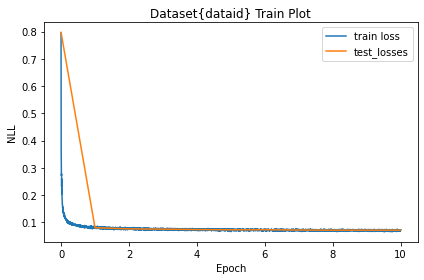

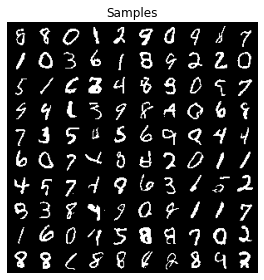

In [0]:
model_save_results(1, model_wrapper, method="GatedPixelCNN")